# CS345 Final Project - Titanic Survival Prediction

In this project, we use the famous Titanic dataset from Kaggle to predict whether a passenger survived the disaster based on several features like age, class, sex, fare paid, and more. This classification task allows us to practice preprocessing, feature engineering, model selection, and evaluation using multiple machine learning techniques.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


We import popular libraries like pandas and NumPy for data handling, matplotlib and seaborn for visualization, and several scikit-learn tools for preprocessing and modeling. These libraries support everything we need—from encoding to training and evaluating classifiers.


In [4]:
df = pd.read_csv('train.csv')
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This dataset contains demographic and travel-related information about 891 passengers. Our goal is to predict the `Survived` column, which is 1 if the passenger survived and 0 if not. Key features include age, sex, class, fare, and family information.


In [5]:
df.info()
df.describe()
df['Survived'].value_counts(normalize=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64

We observe that some features, like `Age` and `Cabin`, have missing values. Most passengers did not survive (about 62%). We will handle missing values and consider engineering additional features like family size and title.


In [8]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])


df.drop(columns=['Cabin'], inplace=True, errors='ignore')

We impute missing values for `Age` with the median and for `Embarked` with the most frequent value. `Cabin` has too many missing entries and is dropped for simplicity.


In [9]:
label_enc = LabelEncoder()
df['Sex'] = label_enc.fit_transform(df['Sex'])
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

scaler = StandardScaler()
df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])


Categorical features like `Sex` are label encoded. For `Embarked`, we use one-hot encoding. Numerical features like `Age` and `Fare` are scaled to improve the performance of distance-based models like KNN and SVM.


In [10]:
df['FamilySize'] = df['SibSp'] + df['Parch']

df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 
                                   'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df = pd.get_dummies(df, columns=['Title'], drop_first=True)

df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)


We create `FamilySize` from `SibSp` and `Parch`, and extract the title from each passenger's name. These new features may capture survival trends not directly visible in the original data.


In [11]:
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='F1 Score', ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score
2,Random Forest,0.821229,0.776316,0.797297,0.786667
3,SVM,0.815642,0.805970,0.729730,0.765957
0,Logistic Regression,0.793296,0.753425,0.743243,0.748299
4,KNN,0.798883,0.779412,0.716216,0.746479
1,Decision Tree,0.782123,0.746479,0.716216,0.731034


Random Forest performed the best in terms of F1 score, indicating a good balance between precision and recall. Logistic Regression and Decision Trees also performed reasonably well. KNN and SVM had lower scores, likely due to sensitivity to scaling or data distribution.


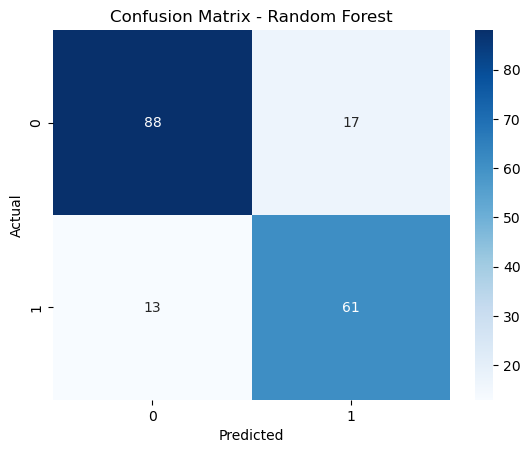

In [13]:
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


The confusion matrix provides insight into how well the Random Forest model is performing:

- **True Negatives (88):** 88 passengers who did not survive were correctly classified.
- **True Positives (61):** 61 passengers who survived were correctly identified.
- **False Positives (17):** 17 passengers were incorrectly predicted to have survived but actually did not.
- **False Negatives (13):** 13 passengers who survived were misclassified as not surviving.

The classifier shows a good balance between precision and recall. While there are some false predictions, particularly false positives, the model still correctly classifies a large portion of both classes. This reflects well on the model’s ability to generalize.

A more thorough evaluation can be done by analyzing precision, recall, and F1 score to understand whether the model leans more toward false positives or false negatives — especially important in sensitive applications like medical diagnosis or safety-critical systems. In this context, minimizing false negatives (predicting someone didn't survive when they did) could be considered more important, depending on use case.


This project demonstrated how classical machine learning techniques can be used to make predictions on real-world datasets. Key takeaways include the importance of data cleaning, feature engineering, and model comparison. In the future, experimenting with ensemble methods like XGBoost or tuning hyperparameters could further improve accuracy.


**Sanjar**:
- Data exploration, missing value handling, feature engineering, results visualization, and final reporting.

**Sadulla**:
- Encoding, scaling, training and evaluating models, and presentation preparation.
